# Long Term Short Term Memory (LSTM) Neural Networks

Notes :

    - I used a serie of blog posts from "Machine Learning Mastery" to help me understand how to implement LSTM neural networks with python. The main one is there: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/. 
    
    - Theoretical explanations of how LSTM networks works : http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
    
    - I reduced the size of the original dataset in order to reduce training time. Took one year of data.  
    
 

### Import packages 

In [32]:
import numpy 
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

import warnings
warnings.filterwarnings("ignore")

### Create useful functions  

In [39]:
def plot_prediction(y_pred, y_test, xlabel, ylabel, title, png):
    plt.figure(0, figsize=(12,5))
    plt.plot(y_pred, '--', c='r', label='pred.', lw=2)
    plt.plot(y_test, c='black', label='actual', lw=2)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=17)
    plt.grid(which = 'both')
    plt.legend(fontsize=13)
    plt.savefig(png)
    plt.show()

In [43]:
#define evaluation function 
def evaluation(y_true, y_pred):
    print("RMSE:", numpy.sqrt(mean_squared_error(y_pred, y_true)))

In [35]:
def create_dataset(dataset, look_back=1):
    """
    author:
    (https://machinelearningmastery.com/
    \time-series-prediction-lstm-recurrent-neural-networks-python-keras/).
    
    This function takes a serie as input and creates X and Y datasets. 
    X is filled with lagged value of Y, lookback argument specifies the number of lag.
    
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

### Prepare Data

In [2]:
#load dataset 
df = pd.read_csv("<INSERT PATH TO DATASET>", usecols=[1])

#Reduce dataset size. Testing data starts on the same date as in previous notebooks  
df = df.iloc[15767:24527]

#extract raw values from DataFrame 
data = df.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train = dataset[:round(len(df)*0.75)]
test = dataset[round(len(df)*0.75):]

# reshape into X=t-24,...,t-1 and Y=t
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Fit LSTM neural network  

In [6]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 23s - loss: 0.0029
Epoch 2/100
 - 25s - loss: 8.9480e-04
Epoch 3/100
 - 19s - loss: 7.4211e-04
Epoch 4/100
 - 21s - loss: 6.6293e-04
Epoch 5/100
 - 19s - loss: 5.9912e-04
Epoch 6/100
 - 17s - loss: 5.7303e-04
Epoch 7/100
 - 17s - loss: 5.5452e-04
Epoch 8/100
 - 17s - loss: 5.3219e-04
Epoch 9/100
 - 16s - loss: 5.2246e-04
Epoch 10/100
 - 16s - loss: 5.0934e-04
Epoch 11/100
 - 16s - loss: 5.1552e-04
Epoch 12/100
 - 16s - loss: 4.9245e-04
Epoch 13/100
 - 14s - loss: 4.9713e-04
Epoch 14/100
 - 11s - loss: 4.9819e-04
Epoch 15/100
 - 11s - loss: 4.8364e-04
Epoch 16/100
 - 11s - loss: 4.8172e-04
Epoch 17/100
 - 11s - loss: 4.8205e-04
Epoch 18/100
 - 11s - loss: 4.7588e-04
Epoch 19/100
 - 11s - loss: 4.7136e-04
Epoch 20/100
 - 11s - loss: 4.6326e-04
Epoch 21/100
 - 12s - loss: 4.7088e-04
Epoch 22/100
 - 11s - loss: 4.6793e-04
Epoch 23/100
 - 12s - loss: 4.7128e-04
Epoch 24/100
 - 11s - loss: 4.6302e-04
Epoch 25/100
 - 11s - loss: 4.6712e-04
Epoch 26/100
 - 12s - loss: 4.5994e-0

In [14]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [45]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.72 RMSE


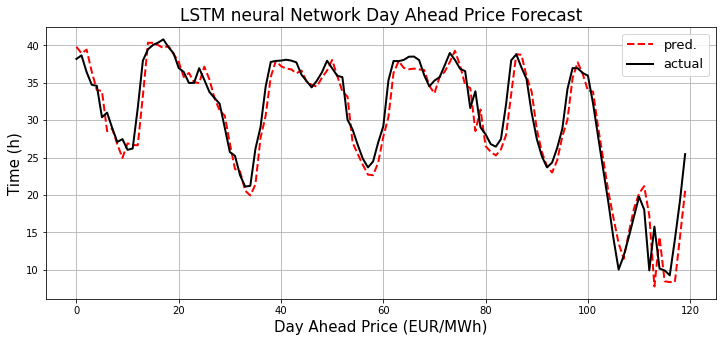

RMSE: 3.7206246063441744


In [75]:
plot_prediction(testPredict[:120], testY.T[:120], "Day Ahead Price (EUR/MWh)", "Time (h)", "LSTM neural Network Day Ahead Price Forecast", "LSTMpricefcst.png")
evaluation(testY.T, testPredict)

### How do the model compare to a naive model?
Here I estimate a naive model where teh prediction is t-1 price to understand the value added of LSTM neural networks relatively to a very simple forecasting model. 

In [69]:
price = pd.DataFrame(testY[0])
price_forecast = price.shift(1).iloc[1:]
price = pd.DataFrame(testY[0]).iloc[1:]

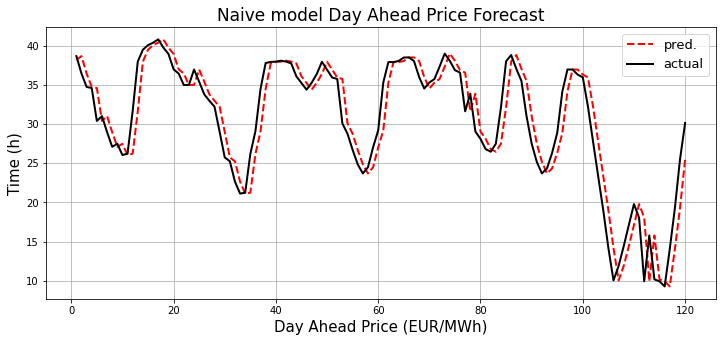

RMSE: 4.645118352273133


In [74]:
plot_prediction(price_forecast.iloc[:120], price.iloc[:120], "Day Ahead Price (EUR/MWh)", "Time (h)", "Naive model Day Ahead Price Forecast", "NAIVEpricefcst.png")
evaluation(price, price_forecast)